# Задание

Постройте график с распределением количества посещений от ботов и обычных пользователей сайта Яндекс.Метрика.

In [1]:
# загружаем библиотеки

import pandas as pd
import seaborn as sns
import requests as rq
import json

import gspread
from df2gspread import df2gspread as d2g
from oauth2client.service_account import ServiceAccountCredentials
from random import random, randrange, getrandbits, randint 


import vk_api

from io import BytesIO

In [2]:
# Считываем данные с Яндекс метрики

# Base url to service
url = 'https://api-metrika.yandex.net/stat/v1/data?'

# &-separated parameters of query in a form of name=value, taken from the metrica site
# date 28/09/2022 - 30/09/2022
visits = 'preset=tech_platforms&date1=2022-09-28&date2=2022-09-30&metrics=ym:s:visits&dimensions=ym:s:date,ym:s:isRobot,ym:s:browser&id=44147844'
url = url + visits

# #Get json of response
query = rq.get(url)
json_data = json.loads(query.text)
json_data



{'query': {'ids': [44147844],
  'preset': 'tech_platforms',
  'dimensions': ['ym:s:date', 'ym:s:isRobot', 'ym:s:browser'],
  'metrics': ['ym:s:visits'],
  'sort': ['-ym:s:visits'],
  'date1': '2022-09-28',
  'date2': '2022-09-30',
  'limit': 100,
  'offset': 1,
  'group': 'Week',
  'auto_group_size': '1',
  'attr_name': '',
  'quantile': '50',
  'offline_window': '21',
  'attribution': 'LastSign',
  'currency': 'RUB',
  'adfox_event_id': '0'},
 'data': [{'dimensions': [{'name': '2022-09-28'},
    {'name': 'People', 'id': 'no'},
    {'icon_id': '6',
     'icon_type': 'browser',
     'name': 'Google Chrome',
     'id': '6'}],
   'metrics': [310.0]},
  {'dimensions': [{'name': '2022-09-29'},
    {'name': 'People', 'id': 'no'},
    {'icon_id': '6',
     'icon_type': 'browser',
     'name': 'Google Chrome',
     'id': '6'}],
   'metrics': [280.0]},
  {'dimensions': [{'name': '2022-09-30'},
    {'name': 'People', 'id': 'no'},
    {'icon_id': '6',
     'icon_type': 'browser',
     'name': 'Go

In [3]:
for i in json_data['data']:
    print(i['dimensions'][0]['name'])
    print(i['metrics'][0])
    print(i['dimensions'][1]['name']),
    print(i['dimensions'][2]['name']),
    print(i['dimensions'][2]['icon_type'])

2022-09-28
310.0
People
Google Chrome
browser
2022-09-29
280.0
People
Google Chrome
browser
2022-09-30
212.0
People
Google Chrome
browser
2022-09-28
132.0
People
Yandex Browser
browser
2022-09-30
75.0
People
Yandex Browser
browser
2022-09-29
65.0
People
Yandex Browser
browser
2022-09-28
55.0
People
Chrome Mobile
browser
2022-09-30
50.0
People
Chrome Mobile
browser
2022-09-28
47.0
People
Edge
browser
2022-09-29
42.0
People
Safari
browser
2022-09-28
41.0
People
Safari
browser
2022-09-29
40.0
People
Edge
browser
2022-09-28
38.0
People
Firefox
browser
2022-09-29
38.0
People
Chrome Mobile
browser
2022-09-29
29.0
People
Opera
browser
2022-09-30
27.0
People
Safari
browser
2022-09-30
27.0
Robots
Google Chrome
browser
2022-09-28
26.0
Robots
Google Chrome
browser
2022-09-29
26.0
People
Firefox
browser
2022-09-30
25.0
People
Mobile Safari
browser
2022-09-28
23.0
People
Opera
browser
2022-09-30
23.0
People
Edge
browser
2022-09-29
19.0
Robots
Google Chrome
browser
2022-09-30
16.0
People
Firefox
bro

In [4]:
# # Conversion of obtained json to dataframe
visits_data = pd.DataFrame([(
                             i['dimensions'][0]['name'],
                             i['metrics'][0],
                             i['dimensions'][1]['name'],
                            i['dimensions'][2]['icon_type'],
                             i['dimensions'][2]['name']) for i in json_data['data']], 
    columns=['date', 'visits','user_types','device','browser'])

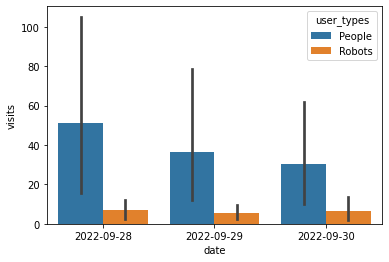

In [5]:
sns.barplot(x=visits_data.date, y=visits_data.visits, hue=visits_data.user_types)

Определите процент посещений сайта Яндекс.Метрики с бразузера Google Chrome.
Ответ округлите до целого.

In [6]:
visits_data.query('browser =="Google Chrome"')['visits'].sum()

874.0

C какого браузера приходит больше всего ботов?

In [7]:
# общее кол-во визитов
visits_data['visits'].sum()

1841.0

In [8]:
# расчет общего кол-ва визитов по браузерам

visits_browser = visits_data.groupby('browser', as_index=False).agg({'visits':'sum'}).\
                    rename(columns={'visits':'all_visits_in_browser'})
visits_browser.head(4)

,browser,all_visits_in_browser
0,Android Browser,9.0
1,Atom,2.0
2,Chrome Mobile,182.0
3,Edge,113.0


In [9]:
# создание нового датафрейма: браузер, кол-во визитов роботов, общее кол-во визитов в браузере
    
result = visits_data.query('user_types == "Robots"').groupby('browser', as_index=False).agg({'visits':'sum'}).\
                    rename(columns={'visits':'robots_visits'}).merge(visits_browser, on='browser', how='left')

In [10]:
# добавление нового стообца СR = визиты роботов / общее кол-во визитов в браузере
result['cr'] = round(result.robots_visits / result.all_visits_in_browser,2)*100

In [11]:
# сортировка по CR по убыванию
result.sort_values(by = 'cr', ascending = False).head(1)

,browser,robots_visits,all_visits_in_browser,cr
4,Firefox Mobile,7.0,8.0,88.0


Создайте колонку с метрикой доли заходов на сайт для каждого из этих разрезов.

В ответе укажите процент открытий сайта настоящими пользователями Safari (не ботами) с точностью до 1 знака после точки.


In [12]:
#считаем общее количество посещений за все дни, которые есть в файле
date_visits=visits_data.groupby('date', as_index=False).agg({'visits':'sum'})
date_visits

,date,visits
0,2022-09-28,731.0
1,2022-09-29,600.0
2,2022-09-30,510.0


In [13]:
#суммируем все посещения в разрезе браузера и типа пользователя в каждую дату
groupall_result = visits_data.groupby(['browser','user_types','date'], as_index=False).agg({'visits':'sum'})
groupall_result

,browser,user_types,date,visits
0,Android Browser,People,2022-09-28,1.0
1,Android Browser,People,2022-09-29,3.0
2,Android Browser,People,2022-09-30,5.0
3,Atom,People,2022-09-28,1.0
4,Atom,Robots,2022-09-30,1.0
...,...,...,...,...
66,Yandex Browser,Robots,2022-09-29,10.0
67,Yandex Browser,Robots,2022-09-30,5.0
68,Яндекс Старт: мобильное приложение,People,2022-09-29,1.0
69,Яндекс Старт: мобильное приложение,People,2022-09-30,5.0


In [14]:
##объединяем таблицы
result_visits = groupall_result.merge(date_visits, on='date').rename(columns={'visits_x':'visits', 'visits_y':'all_visits'})
result_visits

,browser,user_types,date,visits,all_visits
0,Android Browser,People,2022-09-28,1.0,731.0
1,Atom,People,2022-09-28,1.0,731.0
2,Chrome Mobile,People,2022-09-28,55.0,731.0
3,Chrome Mobile,Robots,2022-09-28,15.0,731.0
4,Edge,People,2022-09-28,47.0,731.0
...,...,...,...,...,...
66,Safari,Robots,2022-09-30,1.0,510.0
67,Samsung Internet,People,2022-09-30,4.0,510.0
68,Yandex Browser,People,2022-09-30,75.0,510.0
69,Yandex Browser,Robots,2022-09-30,5.0,510.0


In [15]:
result_visits['cr'] = round(result_visits.visits / result_visits.all_visits * 100,1)
result_visits.query('browser =="Safari" and user_types =="People"')

,browser,user_types,date,visits,all_visits,cr
16,Safari,People,2022-09-28,41.0,731.0,5.6
42,Safari,People,2022-09-29,42.0,600.0,7.0
65,Safari,People,2022-09-30,27.0,510.0,5.3


Отправьте данные из предыдущего шага в Google SpreadSheet. 

Далее отправьте ссылку на получившийся файл в Google SpreadSheet 
(не забудьте открыть доступ по ссылке, это можно сделать вручную, когда данные уже зальются в таблицу) 
при помощи VK API себе в личку ВКонтакте. 

In [16]:
result_visits.head(5)

,browser,user_types,date,visits,all_visits,cr
0,Android Browser,People,2022-09-28,1.0,731.0,0.1
1,Atom,People,2022-09-28,1.0,731.0,0.1
2,Chrome Mobile,People,2022-09-28,55.0,731.0,7.5
3,Chrome Mobile,Robots,2022-09-28,15.0,731.0,2.1
4,Edge,People,2022-09-28,47.0,731.0,6.4


In [17]:
# коннект с Google SpreadSheet

scope = ['https://spreadsheets.google.com/feeds',
        'https://www.googleapis.com/auth/drive']

my_mail = 'pepelyaevai3@gmail.com'

path_to_credentials = '/mnt/HC_Volume_18315164/home-jupyter/jupyter-i-evsa-22/lesson_7/eighth-contact-345812-827127df840c.json'

# Authorization
credentials = ServiceAccountCredentials.from_json_keyfile_name(path_to_credentials, scope)
gs = gspread.authorize(credentials)

In [18]:
# Create empty table
table_name = 'Yandex metrics'
sheet = gs.create(table_name)

# Make it visible to other guys
sheet.share(my_mail, perm_type='user', role='writer')

In [19]:
#указываем таблицу, в которую хотим сгрузить данные
spreadsheet_name = 'Yandex metrics'
sheet = 'Sheet1'
d2g.upload(result_visits, spreadsheet_name, sheet, credentials=credentials, row_names=True)

<Worksheet 'Sheet1' id:0>

In [20]:
# коннект с  VK 

# Token which you obtained via vk
app_token = 'e79eaf25a9b02cd4584be2bf8fcfe3b05a88e333af42f36a45aaaa2a59e2da5c2cbd59ae19a1e95bbdec1'

# id of the 1st chat
chat_id = 2

# id of my user-receiver
my_id = 7151517

# Initialize session
vk_session = vk_api.VkApi(token=app_token)

# Make it possible to use vk api methods as python methods
vk = vk_session.get_api()

#Отправка сообщений

vk.messages.send(
    chat_id=chat_id,
    random_id=155,
    message='Привет! Ссылка на отчет - https://docs.google.com/spreadsheets/d/1io9NF6U_hZ1ZWQaOB6IjXK6ic9xG_Rpn6SgLS3_r6U0/edit#gid=0')

0

Другой аналитик уже агрегировал часть данных из метрики. Вам нужно объединить усилия, чтобы получить финальный отчет. Прочитайте дополнительные данные из Google SpreadSheet, объедините вашу таблицу из предыдущего шага с таблицей аналитика 
и посчитайте количество визитов на человека (отношение visits к users) в разрезе по браузеру и значениям Robots/People.

В ответе укажите, сколько визитов на уникального пользователя совершается ботами с браузера Google Chrome (округлите до целого)

In [30]:
# cчитывание данных от другого аналитика

r = rq.get('https://docs.google.com/spreadsheets/d/e/2PACX-1vQWMsvBTVio9C7IOOxfFO9C15BRHyME-_ENHqBodDOjuiHwk9fCuF5hUVmDs497PZOqPYK3exdSikOK/pub?gid=1006633900&single=true&output=csv')
data = r.content

df_analytic = pd.read_csv(BytesIO(data))


In [42]:
df_analytic.shape
df_analytic.head(5)


,date,browser,user_type,users
0,2020-06-15,Google Chrome,People,240.0
1,2020-06-15,Google Chrome,Robots,104.0
2,2020-06-15,Yandex Browser,People,44.0
3,2020-06-15,Chrome Mobile,People,30.0
4,2020-06-15,Firefox,Robots,29.0


In [43]:
# Считывание данных из моей таблицы

table_name = 'Yandex metrics'  # Your table

# Get this table
work_sheet = gs.open(table_name)

# Select 1st sheet
sheet1 = work_sheet.sheet1

# Get data in python lists format
data = sheet1.get_all_values()

# Get header from data
headers = data.pop(0)

# Create df
my_file = pd.DataFrame(data, columns=headers)
my_file.head()

,browser,user_type,date,visits,all_visits,cr
0,Android Browser,People,2022-09-28,1.0,731.0,0.1
1,Atom,People,2022-09-28,1.0,731.0,0.1
2,Chrome Mobile,People,2022-09-28,55.0,731.0,7.5
3,Chrome Mobile,Robots,2022-09-28,15.0,731.0,2.1
4,Edge,People,2022-09-28,47.0,731.0,6.4


In [45]:
# объединяем данные по 2 таблицам

result = my_file.merge(df_analytic, on=['date','browser','user_type'], how='left')
result

,browser,user_type,date,visits,all_visits,cr,users
0,Android Browser,People,2022-09-28,1.0,731.0,0.1,NaN
1,Atom,People,2022-09-28,1.0,731.0,0.1,NaN
2,Chrome Mobile,People,2022-09-28,55.0,731.0,7.5,NaN
3,Chrome Mobile,Robots,2022-09-28,15.0,731.0,2.1,NaN
4,Edge,People,2022-09-28,47.0,731.0,6.4,NaN
...,...,...,...,...,...,...,...
66,Safari,Robots,2022-09-30,1.0,510.0,0.2,NaN
67,Samsung Internet,People,2022-09-30,4.0,510.0,0.8,NaN
68,Yandex Browser,People,2022-09-30,75.0,510.0,14.7,NaN
69,Yandex Browser,Robots,2022-09-30,5.0,510.0,1.0,NaN


In [58]:
# меняем типы данных в итоговой таблице

result = result.astype({"browser":'string', "user_type":'string', "visits":"float","all_visits":"float","cr":"float","users":"float"}) 
result['date'] = pd.to_datetime(result['date'])

In [61]:
# проверяем результаты конвертации

result.dtypes

browser               string
user_type             string
date          datetime64[ns]
visits               float64
all_visits           float64
cr                   float64
users                float64
dtype: object

In [62]:
#считаем общее количество посещений за все дни, которые есть в файле

date_visits=result.groupby('date', as_index=False).agg({'visits':'sum'})
date_visits

,date,visits
0,2022-09-28,731.0
1,2022-09-29,600.0
2,2022-09-30,510.0


In [64]:
#суммируем все посещения в разрезе браузера и типа пользователя в каждую дату
groupall_result = result.groupby(['browser','user_type','date'], as_index=False).agg({'visits':'sum'})
groupall_result

,browser,user_type,date,visits
0,Android Browser,People,2022-09-28,1.0
1,Android Browser,People,2022-09-29,3.0
2,Android Browser,People,2022-09-30,5.0
3,Atom,People,2022-09-28,1.0
4,Atom,Robots,2022-09-30,1.0
...,...,...,...,...
66,Yandex Browser,Robots,2022-09-29,10.0
67,Yandex Browser,Robots,2022-09-30,5.0
68,Яндекс Старт: мобильное приложение,People,2022-09-29,1.0
69,Яндекс Старт: мобильное приложение,People,2022-09-30,5.0


In [65]:
##объединяем таблицы
df_result = groupall_result.merge(date_visits, on='date').rename(columns={'visits_x':'visits', 'visits_y':'all_visits'})
df_result['cr'] = round(result.visits / result.all_visits * 100,1)
df_result



,browser,user_type,date,visits,all_visits,cr
0,Android Browser,People,2022-09-28,1.0,731.0,0.1
1,Atom,People,2022-09-28,1.0,731.0,0.1
2,Chrome Mobile,People,2022-09-28,55.0,731.0,7.5
3,Chrome Mobile,Robots,2022-09-28,15.0,731.0,2.1
4,Edge,People,2022-09-28,47.0,731.0,6.4
...,...,...,...,...,...,...
66,Safari,Robots,2022-09-30,1.0,510.0,0.2
67,Samsung Internet,People,2022-09-30,4.0,510.0,0.8
68,Yandex Browser,People,2022-09-30,75.0,510.0,14.7
69,Yandex Browser,Robots,2022-09-30,5.0,510.0,1.0
